In [1]:
import pandas as pd
from IPython.display import Image
from notebooks.library.display import toggle_input_code
#toggle_input_code()

The metal is 20 nm aluminum. The complex conductivity is what we expect at 200 mK if only thermal quasiparticles are present.
This gives surface resistance $R_s = 0.44 \, \mu \Omega / \square$ and surface reactance $X_s = 0.030 \, \Omega / \square$.

The substrate is silicon with zero conductivity and zero loss tangent.

The simulated resonator is pictured below. It has few bends so that it can be simulated more quickly. Each simulation takes about a day on a 24-core machine.

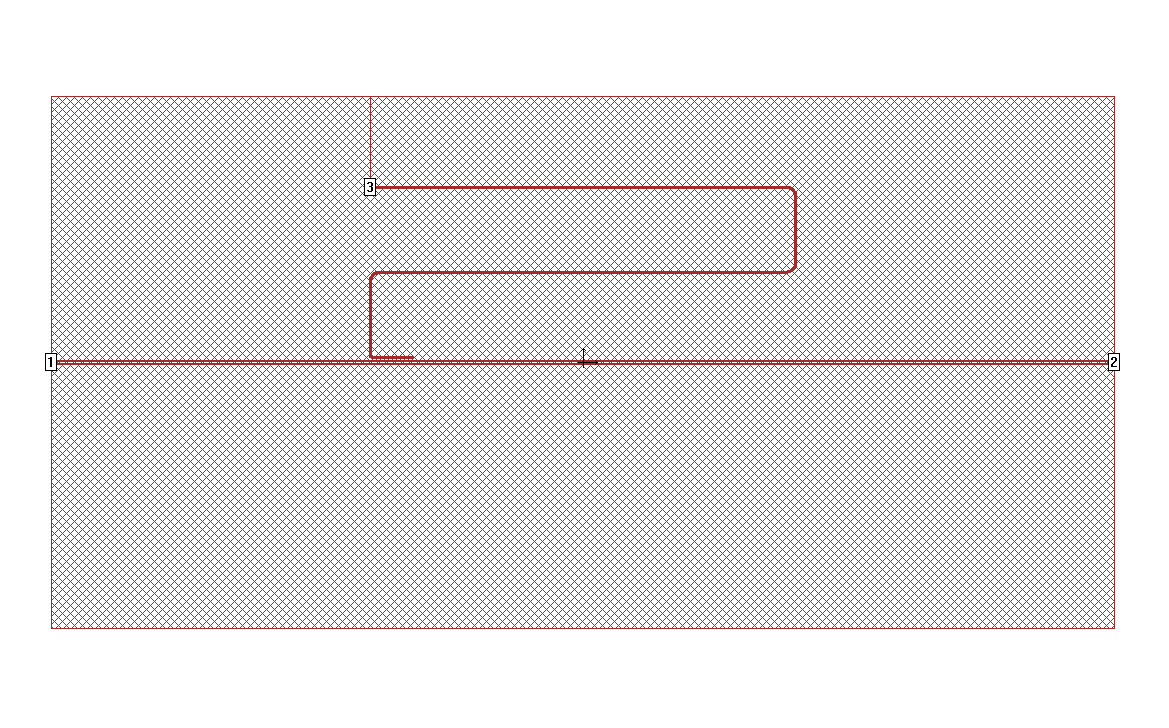

In [2]:
Image(filename='/Users/daniel/Dropbox/multichroic/one_light_lossless_dielectric.png') 

To extract the resonance frequency and quality factor in a reasonable amount of time, we use a technique described in Wisbey et al. JLTP (2014): <a href=http://link.springer.com/article/10.1007%2Fs10909-014-1099-3>New Method for Determining the Quality Factor and Resonance Frequency of Superconducting Micro-Resonators from Sonnet Simulations</a>

The technique involves an internal port in the resonator, in this case port 3, at the shorted end.
Near resonance, the input impedance is

$$
Z_{33}(f)
  =
  R [1 + 2 \mathrm{j} Q (f / f_r - 1)].
$$

The resonance frequency is the frequency at which the imaginary part of the input impedance vanishes, and the quality factor can be calculated from the real part and the slope of the imaginary part of the impedance at $f_r$:

\begin{align}
\mathrm{Im} \, Z_{33}(f_r)
  &=
  0; \\
Q
  &=
  \frac{f_r \, \mathrm{d} (\mathrm{Im} \, Z_{33}(f)) / \mathrm{d} f}{2 \mathrm{Re} \, Z_{33}(f_r)}.
\end{align}

In [3]:
# Load data
z = pd.read_csv('/Users/daniel/Dropbox/multichroic/one_light_lossless_dielectric_0.2K.csv', header=7, delimiter=',')
z.f = 1e9 * z.Frequency_GHz

In [5]:
s = pd.read_csv('/Users/daniel/Dropbox/multichroic/one_light_lossless_dielectric_0.2K_fine_S.csv', header=7, delimiter=',')
s.f = 1e9 * s.Frequency_GHz

In [6]:
re_poly = np.polyfit(z.f, z.REZ33, 2)
im_poly = np.polyfit(z.f, z.IMZ33, 1)

f_r = -im_poly[1] / im_poly[0]
R = np.polyval(re_poly, f_r)
Q = im_poly[0] * f_r / (2 * R)

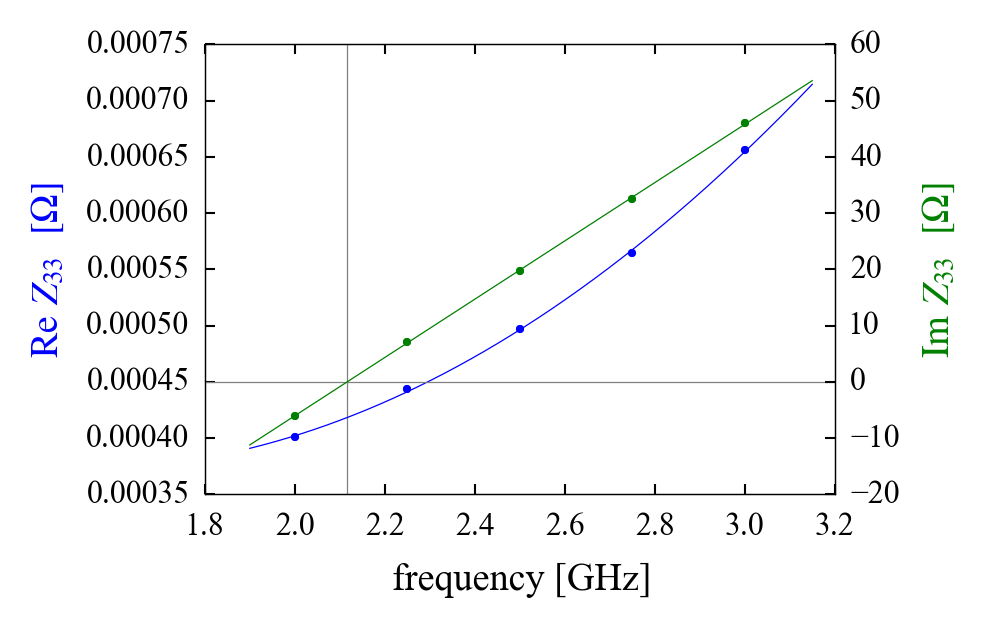

In [7]:
re_color = 'blue'
im_color = 'green'
scale = 1e-9
f_fit = np.linspace(0.95 * z.f.min(), 1.05 * z.f.max(), 1e3)
fig, re_ax = plt.subplots()
im_ax = re_ax.twinx()
im_ax.axhline(0, color='gray')
re_ax.axvline(scale * f_r, color='gray')
re_ax.plot(scale * z.f, z.REZ33, '.', color=re_color, label='re Z33')
re_ax.plot(scale * f_fit, np.polyval(re_poly, f_fit), color=re_color)
im_ax.plot(scale * z.f, z.IMZ33, '.', color=im_color, label='im Z33')
im_ax.plot(scale * f_fit, np.polyval(im_poly, f_fit), color=im_color)
re_ax.set_xlabel('frequency [GHz]')
re_ax.set_ylabel(r'$\mathrm{Re} \, Z_{33} \; [\Omega]$', color=re_color)
im_ax.set_ylabel(r'$\mathrm{Im} \, Z_{33} \; [\Omega]$', color=im_color);

As shown in the plot above, we fit a line to $\mathrm{Im} \, Z_{33}$ and a quadratic to $\mathrm{Re} \, Z_{33}$ to determine the parameters. The results are

In [8]:
print("Measured resonance f_r = {:.3f} [GHz]".format(1e-9 * f_r))
print("Quality factor Q = {:.2g}".format(Q))

Measured resonance f_r = 2.116 [GHz]
Quality factor Q = 1.3e+05


(2.116, 2.1162)

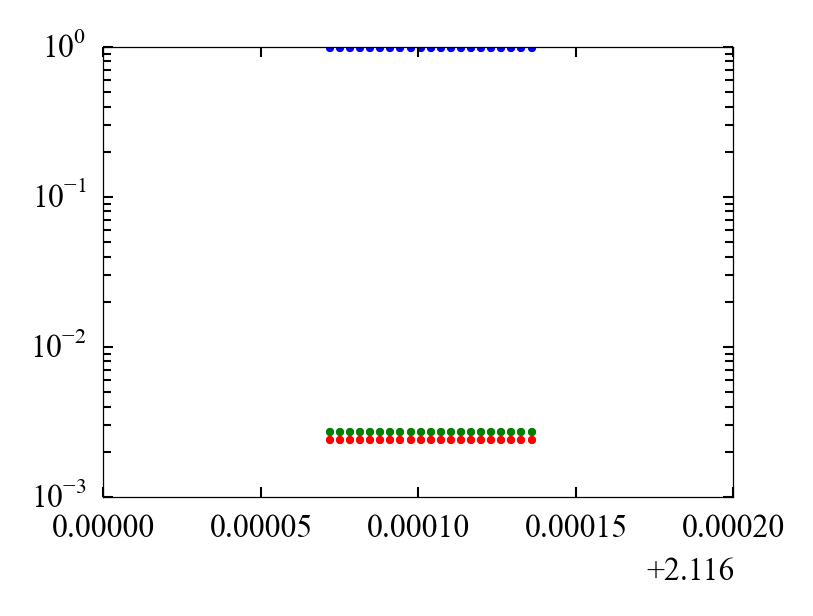

In [24]:
scale = 1e-9
fig, ax = plt.subplots()
ax.semilogy(scale * s.f, np.abs(s.RES21 + 1j * s.IMS21), '.')
ax.plot(scale * s.f, np.abs(s.RES31 + 1j * s.IMS31), '.')
ax.plot(scale * s.f, np.abs(s.RES32 + 1j * s.IMS32), '.')
ax.set_xlim(2.116, 2.1162)

The length of the resonator is $a = 10$ mm. Ignoring kinetic inductance and using a dielectric constant of $\epsilon_r = 11.9$ for silicon would give an expected resonance frequency

$$
f_0 = \frac{c a}{4 [(1 + \epsilon_r) / 2]^{1/2}}
  \approx 3 \, \mathrm{GHz},
$$

or

In [10]:
from scipy.constants import c
a = 10e-3
epsilon_r = 11.9
epsilon_eff = (1 + epsilon_r) / 2
v = c / epsilon_eff**(1/2)
f_0 = v / (4 * a)
print("Expected resonance f_0 = {:.3f} [GHz]".format(1e-9 * f_0))

Expected resonance f_0 = 2.951 [GHz]


We can use this to determine the kinetic inductance fraction

$$
\alpha
  =
  \frac{L_k}{L_g + L_k}
  =
  1 - \left( \frac{f_r}{f_0} \right)^2,
$$

or

In [11]:
alpha = 1 - (f_r / f_0)**2
print("kinetic inductance fraction: {:.2f}".format(alpha))

kinetic inductance fraction: 0.49


In [12]:
linewidth = f_r / Q
linewidth

16146.638341447946

In [13]:
1e-9 * linewidth / 5

3.2293276682895893e-06

In [14]:
step = 3.2e3

In [15]:
f_r

2116103654.626543

In [16]:
f_r_rounded = 2.116104e9

In [17]:
f_r_rounded - f_r

345.37345695495605

In [18]:
1e-9 * (f_r - 2 * linewidth)

2.1160713613498605

In [19]:
1e-9 * (f_r_rounded - 10 * step)

2.116072

In [20]:
1e-9 * (f_r + 2 * linewidth)

2.116135947903226

In [21]:
1e-9 * (f_r_rounded + 10 * step)

2.116136